# Computer Vision Homework 
## Part 1 - Lucas-Kanade algorithm + Template matching

In [1]:
import cv2
import os
import numpy as np
from PIL import Image
from time import time
import matplotlib.pyplot as plt

os.chdir('..')

In [2]:
from utils.data_manipulation import read_data, record_video
from utils.transformations import warp, roi_to_points,\
                                 indexes, to_rectangle,\
                                 affine_2d_transform, transform_points

from utils.data_manipulation import read_data, record_video
from utils.metrics import ssd, sad, ncc

# Download data

In [3]:
human = read_data('Human4', grayscale=True)
biker = read_data('Biker', grayscale=True)
skater = read_data('Skater', grayscale=True)

In [4]:
human_rgb = read_data('Human4', grayscale=False)
biker_rgb = read_data('Biker', grayscale=False)
skater_rgb = read_data('Skater', grayscale=False)

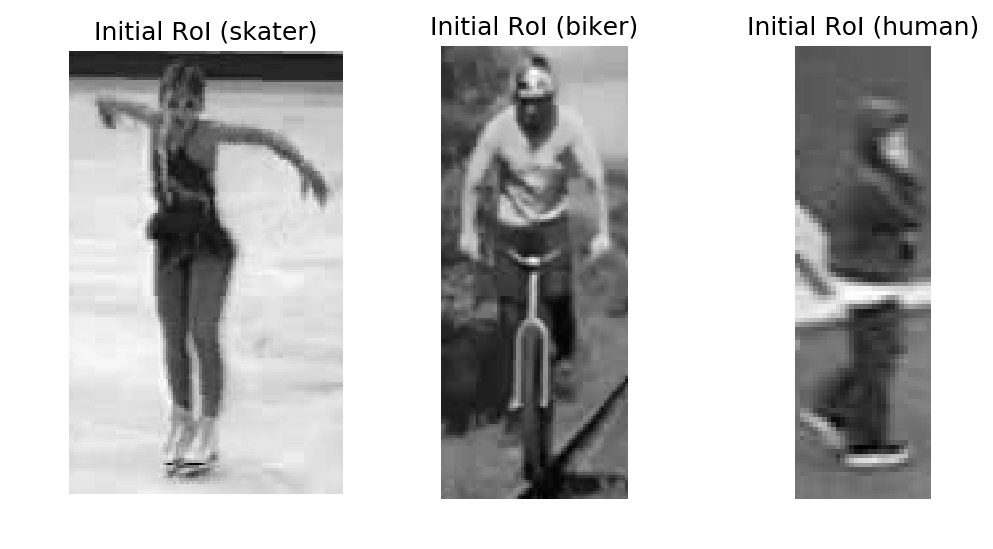

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 4), dpi=150)

axes[0].imshow(skater[0][50:220, 110:215], cmap='gray')
axes[0].axis('off')
axes[0].set_title('Initial RoI (skater)')

axes[1].imshow(biker[0][90:260, 235:305], cmap='gray')
axes[1].axis('off')
axes[1].set_title('Initial RoI (biker)')

axes[2].imshow(human[0][225:325, 95:125], cmap='gray')
axes[2].axis('off')
_ = axes[2].set_title('Initial RoI (human)')

## Template matching

Template matching with SSD

Via terminal (run commands in the root folder):

In [6]:
!python template_matching.py --roi 90 260 235 305 --metric ssd --data Biker --output_video biker_template_matching_ssd --verbose 0

Template matching algorithm: 
Overall computation time - 10.4159 minutes


In [7]:
!python template_matching.py --roi 50 220 110 215 --metric ssd --data Skater --output_video skater_template_matching_ssd --verbose 0

Template matching algorithm: 
Overall computation time - 2.4473 minutes


In [8]:
!python template_matching.py --roi 225 325 95 125 --metric ssd --data Human4 --output_video biker_template_matching_ssd --verbose 0

Template matching algorithm: 
Overall computation time - 8.6623 minutes


Via notebook:

In [47]:
rois = template_matching(biker, (90, 260, 235, 305), ssd, verbose=False)
record_video(rois, biker_rgb, 'biker_template_matching_ssd')

KeyboardInterrupt: 

In [45]:
rois = template_matching(skater, (50, 220, 110, 215), ssd, verbose=False)
record_video(rois, skater_rgb, 'skater_template_matching_ssd')

Template matching algorithm: 
Overall computation time - 1.8998 minutes


In [348]:
rois = template_matching(human[:113], (225, 325, 95, 125), ssd, verbose=False)
save_video(rois, human_rgb, 'human_template_matching_ssd')

Template matching algorithm: 
Overall computation time - 6.3986 minutes


Template matching with NCC

Via terminal (run commands in the root folder):

In [ ]:
!python template_matching.py --roi 90 260 235 305 --metric ncc --data Biker --output_video biker_template_matching_ssd --verbose 0

In [ ]:
!python template_matching.py --roi 50 220 110 215 --metric ncc --data Skater --output_video skater_template_matching_ssd --verbose 0

In [ ]:
!python template_matching.py --roi 225 325 95 125 --metric ncc --data Human4 --output_video biker_template_matching_ssd --verbose 0

Via notebook:

In [0]:
rois = template_matching(biker, (90, 260, 235, 305), ncc, verbose=False)
save_video(rois, biker_rgb, 'biker_template_matching_ncc')

In [0]:
rois = template_matching(skater, (50, 220, 110, 215), ncc, verbose=False)
save_video(rois, skater_rgb, 'skater_template_matching_ncc')

In [0]:
rois = template_matching(human[:113], (225, 325, 95, 125), ncc, verbose=False)
save_video(rois, human_rgb, 'human_template_matching_ncc')

Template matching with SAD

Via terminal (run commands in the root folder):

In [ ]:
!python template_matching.py --roi 90 260 235 305 --metric sad --data Biker --output_video biker_template_matching_ssd --verbose 0

In [ ]:
!python template_matching.py --roi 50 220 110 215 --metric sad --data Skater --output_video skater_template_matching_ssd --verbose 0

In [ ]:
!python template_matching.py --roi 225 325 95 125 --metric sad --data Human4 --output_video biker_template_matching_ssd --verbose 0

Via notebook:

In [0]:
rois = template_matching(biker, (90, 260, 235, 305), sad, verbose=False)
save_video(rois, biker_rgb, 'biker_template_matching_sad')

In [0]:
rois = template_matching(skater, (50, 220, 110, 215), sad, verbose=False)
save_video(rois, skater_rgb, 'skater_template_matching_sad')

In [0]:
rois = template_matching(human[:113], (225, 325, 95, 125), sad, verbose=False)
save_video(rois, human_rgb, 'human_template_matching_sad')

### Lucas-Kanade algorithm with affine warping transformation of the Region of Interest (ROI):

In [19]:
def warp(params):
    
    matrix = np.array([[1.0 + params[0], 0.0 + params[2], 0.0 + params[4]],
                       [0.0 + params[1], 1.0 + params[3], 0.0 + params[5]]])
    
    return matrix

def roi_to_points(roi):
    
    top_left = np.array([roi[0], roi[2]])
    top_right = np.array([roi[0], roi[3]])
    bottom_left = np.array([roi[1], roi[2]])
    bottom_right = np.array([roi[1], roi[3]])
    
    l = []
    l.append(top_left)
    l.append(top_right)
    l.append(bottom_left)
    l.append(bottom_right)
    l = np.array(l).astype(np.int32)
    
    return l
  
def indexes(shape):
    X, Y = np.meshgrid(range(shape[0]), range(shape[1]))
    indexes = np.array([X.flatten(), Y.flatten()]).transpose().reshape((shape[0],
                                                                        shape[1],
                                                                        2))
    return indexes
  
def to_rectangle(roi):
    result = (roi[:, 0].min(), roi[:, 0].max(), roi[:, 1].min(), roi[:, 1].max())
    return result

def affine_2d_transform(image, params):
    rows, cols = image.shape[:2]
    matrix = warp(params)
    result = cv2.warpAffine(image, matrix, (cols, rows), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return result
  
def transform_points(points, params):
    
    points = np.flip(points, axis=1)
    points = list(map(lambda x: warp(params) @ np.hstack((x, 1.0)), points))
    points = np.array(points, dtype=np.int32)
    points = np.flip(points, axis=1)
    
    return points

In [28]:
def lucas_kanade(video, initial_roi, eps, verbose=False):
    
    rois = [roi_to_points(initial_roi)]
    
    all_time = 0
    
    for i in range(1, len(video)):
        
        start = time()
        
        old_frame = video[i-1]
        new_frame = video[i]
        
        iters = 1
        params = np.zeros(6)
        
        while True:
            
            # unpack the current roi
            roi = to_rectangle(rois[-1])
            
            # cut template
            template = old_frame[roi[0]:roi[1],
                                 roi[2]:roi[3]]
          
            # warp the destination image with transformation
            warped = affine_2d_transform(new_frame, params)
            warped = warped[roi[0]:roi[1],
                            roi[2]:roi[3]]
                                    
            # compute error
            error = np.subtract(template, warped, dtype=np.float64)
            
            # warp the gradient of image with transformation
            gradient_x = cv2.Sobel(new_frame, cv2.CV_32F, 1, 0, ksize=3)
            gradient_y = cv2.Sobel(new_frame, cv2.CV_32F, 0, 1, ksize=3)
                        
            gradient_x = gradient_x[roi[0]:roi[1],
                                    roi[2]:roi[3]]
            gradient_y = gradient_y[roi[0]:roi[1],
                                    roi[2]:roi[3]]
            
            warped_gradient_x = affine_2d_transform(gradient_x, params)
            warped_gradient_y = affine_2d_transform(gradient_y, params)
            
            warped_gradient = np.dstack((warped_gradient_x, 
                                         warped_gradient_y))
            
            # compute indexes for jacobian
            template_indexes = indexes(template.shape) 
            
            # compute jacobian
            jacobian_matrix = np.concatenate((
                            np.einsum('ij,km->ijkm', template_indexes[..., 0].astype(np.int32), np.eye(2)),
                            np.einsum('ij,km->ijkm', template_indexes[..., 1].astype(np.int32), np.eye(2)),
                            np.einsum('ij,km->ijkm', np.ones(template.shape), np.eye(2))), axis=3)
            
            # compute steepest images
            steepest_images = np.einsum('ijk,ijkm->ijm', warped_gradient, jacobian_matrix)
            
            # compute hessian and its inverse
            hessian = np.einsum('ijk,ijt->ijkt', steepest_images, steepest_images).sum(axis=(0, 1))
            inv_hessian = np.linalg.inv(hessian)
            
            # compute delta_p
            delta_p = inv_hessian @ np.einsum('ijk,ij->ijk', steepest_images, error).sum(axis=(0, 1))
            
            if np.linalg.norm(delta_p) < eps:
                break
                
            if iters > 50:
                break
                
            params += delta_p
            iters += 1
        
        rois.append(transform_points(rois[-1], params))
        
        delta_t = time() - start
        all_time += delta_t
        if verbose:
            print('{} iteration: {:.4f} seconds'.format(i, delta_t))
    
    print('Lucas-Kanade algorithm: ')
    print('Overall computation time - {:.4f} minutes'.format(all_time / 60.0))
    
    return rois

Via terminal (run in the root directory):

In [ ]:
!python lucas-kanade.py --roi 90 260 235 305 --data Biker --eps 1e-1 --output biker-lk --verbose 0

In [ ]:
!python lucas-kanade.py --roi 50 220 110 215 --data Skater --eps 1e-1 --output skater-lk --verbose 0

In [ ]:
!python lucas-kanade.py --roi 225 325 95 125 --data Human4 --eps 1e-2 --output human-lk --verbose 0

Via notebook:

In [32]:
rois_biker = lucas_kanade(biker, (90, 260, 235, 305), eps=1e-1)

Lucas-Kanade algorithm: 
Overall computation time - 0.1710 minutes


In [30]:
rois_human = lucas_kanade(human[:113], (225, 325, 95, 125), eps=1e-2)

Lucas-Kanade algorithm: 
Overall computation time - 0.5432 minutes


In [33]:
rois_skater = lucas_kanade(skater, (50, 220, 110, 215), eps=1e-1)

Lucas-Kanade algorithm: 
Overall computation time - 0.4585 minutes


In [42]:
record_video(rois_biker, biker_rgb, 'biker_lk', mode='polygon')
record_video(rois_human, human_rgb[:113], 'human_lk', mode='polygon')
record_video(rois_skater, skater_rgb, 'skater_lk', mode='polygon')